<a href="https://colab.research.google.com/github/dharmendra7/ReAct-agent-from-scratch-with-Gemini-2.5-and-LangGraph/blob/main/Weather_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install langgraph langchain-google-genai geopy requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requ

In [ ]:
import os

# Read your API key from the environment variable or set it manually
api_key = os.getenv("GEMINI_API_KEY","xxx")

In [15]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [27]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    print(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            print(data)
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}

tools = [get_weather_forecast]

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Create LLM class
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.0-flash", # replace with "gemini-2.0-flash"
    temperature=1.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key=api_key,
)

# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])

# Test the model with tools
model.invoke("What is the weather in Berlin on 12th of March 2025?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-03-12", "location": "Berlin"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--470d6404-633b-444b-8b0d-1c712ed05518-0', tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-03-12', 'location': 'Berlin'}, 'id': 'dba41e8b-37c0-49c1-aa98-a9035f679114', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'output_tokens': 18, 'total_tokens': 117, 'input_token_details': {'cache_read': 0}})

In [29]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
# system_prompt = SystemMessage(
#     "You are a helpful assistant that use tools to access and retrieve information from a weather API. Today is 2025-03-04. Help the user with their questions. Use the history to answer the question."
# )

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

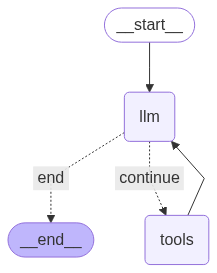

In [30]:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in jammu and kashmir on 12th of August 2025?")]}

# call our graph with streaming to see the steps

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in jammu and kashmir on 12th of August 2025?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (a91b17bc-351e-4517-a352-3d098020ae3a)
 Call ID: a91b17bc-351e-4517-a352-3d098020ae3a
  Args:
    date: 2025-08-12
    location: jammu and kashmir
Jammu and Kashmir, India
{'latitude': 33.75, 'longitude': 75.125, 'generationtime_ms': 0.03039836883544922, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 1643.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-08-12T00:00', '2025-08-12T01:00', '2025-08-12T02:00', '2025-08-12T03:00', '2025-08-12T04:00', '2025-08-12T05:00', '2025-08-12T06:00', '2025-08-12T07:00', '2025-08-12T08:00', '2025-08-12T09:00', '2025-08-12T10:00', '2025-08-12T11:00', '2025-08-12T12:00', '2025-08-12T13:00', '2025-08-12T14:00', '2025

In [39]:
state["messages"].append(("user", "Would it be in Kedarnath warmer?"))


for state in graph.stream(state, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

Would it be in Kedarnath warmer?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (25032817-46d5-466c-82be-7f273f87b6ce)
 Call ID: 25032817-46d5-466c-82be-7f273f87b6ce
  Args:
    date: 2025-08-12
    location: Kedarnath
Kedarnath, Ukhimath, Rudraprayag, Uttarakhand, India
{'latitude': 30.625, 'longitude': 79.25, 'generationtime_ms': 0.8889436721801758, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 3544.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-08-12T00:00', '2025-08-12T01:00', '2025-08-12T02:00', '2025-08-12T03:00', '2025-08-12T04:00', '2025-08-12T05:00', '2025-08-12T06:00', '2025-08-12T07:00', '2025-08-12T08:00', '2025-08-12T09:00', '2025-08-12T10:00', '2025-08-12T11:00', '2025-08-12T12:00', '2025-08-12T13:00', '2025-08-12T14:00', '2025-08-12T15:00